In [207]:
from random import choice, sample, randrange, random, shuffle
from string import ascii_lowercase
import numpy as np
from itertools import permutations
import multiprocessing as mult
import eval_models as evalmod
import seaborn as sns
import matplotlib.pyplot as plt

### Setting the precalculated values

In [2]:
valid_inputs = []
with open("valid-wordle-words.txt") as f:
    valid_inputs = f.read().splitlines()
comparer = set(valid_inputs)
valid_mutations = {}
alphabet = list(map(chr, range(97, 123)))
for word in valid_inputs:
    valid_mutations[word] = set()
    for i in range(len(word)):
        for letter in alphabet:
            if (letter != word[i]) and ((word[:i] + letter + word[i+1:]) in comparer):
                valid_mutations[word].add(word[:i] + letter + word[i+1:])

valid_inputs = []
with open("valid-wordle-words.txt") as f:
    valid_inputs = f.read().splitlines()
comparer = set(valid_inputs)
valid_permutations = {}
changes = [[i,j] for i in range(5) for j in range(i+1,5)]
for word in valid_inputs:
    valid_permutations[word] = set()
    for i,j in changes:
        swap = list(word)
        swap[i], swap[j] = swap[j], swap[i]
        swap = ''.join(swap)
        if swap != word and swap in comparer:
            valid_permutations[word].add(swap)               

valid_inputs = []
with open("valid-wordle-words.txt") as f:
    valid_inputs = f.read().splitlines()
comparer = set(valid_inputs)
valid_inversions = {}
inversions = [[i,j]for i in range(4) for j in range(i+1,5)]
for word in valid_inputs:
    valid_inversions[word] = set()
    for i,j in inversions:
        inv = list(word)
        inv[i:j+1] = reversed(word[i:j+1])
        inv = ''.join(inv)
        if inv != word and inv in comparer:
            valid_inversions[word].add(inv)
alphabet = np.asarray(list(map(chr, range(97, 123))))
def get_keys(alphabet, length):
    if len(alphabet) == 1:
        return np.asarray([alphabet[0]*length])
    elif length == 1:
        return alphabet
    else:
        res = np.asarray([])
        for i in range(len(alphabet)):
            aux = np.asarray(get_keys(alphabet[i:], length - 1))
            res = np.concatenate((res,np.char.add(np.asarray([alphabet[i]]*len(aux)), 
                                         aux)), axis = 0)
        return res
def get_words(key):
    res = set()
    p = permutations(key)
    for word in list(p):
        aux = ''.join(word)
        if aux in comparer:
            res.add(aux)
    return res
keys = get_keys(alphabet, 5)
words_from_letters = {key : get_words(key) for key in keys}

### Loading the frequency data

In [3]:
frecs_new = np.load('adjusted_word_frequency_per_cluster.npy', allow_pickle = True)
frec0_new = frecs_new[0]
frec1_new = frecs_new[1]
frec2_new = frecs_new[2]

frecs = np.load('new_word_frequency_per_cluster.npy', allow_pickle = True)
frec0 = frecs[0]
g0_sorted = sorted(frec0.items(), key=lambda x:x[1], reverse = True)
g0_top = g0_sorted[:30]
g0_top = np.asarray(g0_top)
top_vals = g0_top[:,1].astype(float)
top_vals = top_vals/top_vals.sum()
top_labels = g0_top[:,0]

### Loading the daily words

In [4]:
#dictionary of games and target words
game_dict = {}
with open("wordle-words-by-day2.txt") as f:
    for line in f:
        line = line.strip()
        game_dict.update({int(line[0:3]) : line[4::]})
daily_words = list(game_dict.values())

### Code for the model

In [5]:
from random import choice, sample, randrange, random, shuffle
from string import ascii_lowercase
import numpy as np
from itertools import permutations
import multiprocessing as mult

def find(s, ch):
    return [i for i, ltr in enumerate(s) if ltr == ch]

def check_words(input_word ,target):
    input_word = input_word.lower()
    target = target.lower()
    sequence = ['⬜']*5
    selected = [False]*5
    for i in range(0,5):
        if input_word[i] == target[i]:
            sequence[i] = '🟩'
            selected[i] = True
    for i in range(0,5):
        if input_word[i] != target[i]:
            indexes = find(target, input_word[i])
            for index in indexes:
                if not selected[index]:
                    selected[index] = True
                    sequence[i] = '🟨'
                    break
    aux = ""
    return aux.join(sequence)

def fitness(word, game_state):
    sum = 0
    for guess, result in game_state:
        match = result.count('🟩')
        misplaced =  result.count('🟨')
        result = check_words(guess, word)
        pos_match = result.count('🟩')
        pos_misplaced = result.count('🟨')
        sum += abs(pos_match - match) + abs(pos_misplaced - misplaced) + abs(match + misplaced - pos_match - pos_misplaced)
    return sum


def first_word(labels, vals):
    return labels[np.random.choice(len(labels), p = vals)]

def update_dict(dict_frec):
    frecs = np.asarray(list(dict_frec.values()))
    frecs = frecs/frecs.sum()
    return dict(zip(dict_frec.keys(), frecs))

def mutate2(word, dict_frec, game_state, prob=0.03):
    if random() < prob and len(valid_mutations[word]) > 0:
        fit = 0
        res = word
        for mut in valid_mutations[word]:
            if mut in dict_frec.keys() and fitness(mut,game_state) > fit:
                fit = fitness(mut,game_state)
                res = mut
        return res
    return word

def permute2(word, dict_frec, game_state, prob=0.03):
    if random() < prob and len(valid_permutations[word]) > 0:
        fit = 0
        res = word
        for mut in valid_permutations[word]:
            if mut in dict_frec and fitness(mut,game_state) > fit:
                fit =fitness(mut,game_state)
                res = mut
        return res
    return word

def invert2(word, dict_frec, game_state, prob=0.02):
    if random() < prob and len(valid_inversions[word]) > 0:
        fit = 0
        res = word
        for inv in valid_inversions[word]:
            if inv in dict_frec and fitness(inv,game_state) > fit:
                fit = fitness(inv,game_state)
                res = inv
        return res
    return word


def get_keys(alphabet, length):
    if len(alphabet) == 1:
        return np.asarray([alphabet[0]*length])
    elif length == 1:
        return alphabet
    else:
        res = np.asarray([])
        for i in range(len(alphabet)):
            aux = np.asarray(get_keys(alphabet[i:], length - 1))
            res = np.concatenate((res,np.char.add(np.asarray([alphabet[i]]*len(aux)), 
                                         aux)), axis = 0)
        return res

def get_words(key):
    res = set()
    p = permutations(key)
    for word in list(p):
        aux = ''.join(word)
        if aux in comparer:
            res.add(aux)
    return res

def crossover2(parent1, parent2, dict_prob, game_state, prob=0.5):
    child1, child2 = parent1, parent2
    if random() < prob:
        split = randrange(1, len(parent1)-1)
        child1 = parent1[:split] + parent2[split:]
        child2 = parent2[:split] + parent1[split:]
        if child1 not in dict_prob:
            key1 = ''.join(sorted(child1))
            if len(words_from_letters[key1]) > 0:
                fit = 0
                child1 = np.random.choice(a = np.asarray(list(dict_prob.keys())))
                for cand1 in words_from_letters[key1]:
                    if cand1 in dict_prob and fitness(cand1, game_state) > fit:
                        fit = fitness(cand1, game_state)
                        child1 = cand1
        if child2 not in dict_prob:
            key1 = ''.join(sorted(child2))
            if len(words_from_letters[key1]) > 0:
                fit = 0
                child2 = np.random.choice(a = np.asarray(list(dict_prob.keys())))
                for cand1 in words_from_letters[key1]:
                    if cand1 in dict_prob and fitness(cand1, game_state) > fit:
                        fit = fitness(cand1, game_state)
                        child2 = cand1
    return [child1, child2]


def selection2(fitnesses, population, k=20, keep_size=True):
    if all(fit == 0 for fit in fitnesses):
        return np.random.choice(a=population, replace = True, size = len(fitnesses))
    props = np.asarray(fitnesses)/np.asarray(fitnesses).sum()
    return np.random.choice(a=population, p = props, replace = True, size = len(fitnesses))

def remove_impossible_words(game_state, list_frec):
    guess, result = game_state[-1]
    correct_letters = [(guess[i], i) for i in range(len(guess)) if result[i] == '🟩']
    impossible_words = [word for word in list_frec.keys() if (any(word[i] != guess for guess, i in correct_letters))]
    new_list = {key: value for key,value in list_frec.items() if key not in impossible_words}
    new_list.pop(result,None)
    incorrect_letters = [(guess[i], i) for i in range(len(guess)) if result[i] == '⬜']
    impossible_words = [word for word in new_list.keys() if (any(word[i] == guess for guess, i in incorrect_letters))]
    for word in impossible_words:
        new_list.pop(word)
    misplaced_letters = [(guess[i], i) for i in range(len(guess)) if result[i] == '🟨']
    misplaced_words = [word for word in new_list.keys() if (any(word[i] == guess for guess, i in misplaced_letters))]
    for word in misplaced_words:
        new_list.pop(word)
    invalid_words = [word for word in new_list.keys() if (any(guess not in word for guess, _ in misplaced_letters))]
    for word in invalid_words:
        new_list.pop(word)
    return new_list


def find_best_word(eligible_words, game_state, dict_frec):
    fit = float('inf')
    frec = -1
    best = ''
    for word in eligible_words:
        aux = fitness(word, game_state)
        aux2 = dict_frec[word]
        if aux < fit or (aux == fit and aux2 > frec):
            best = word
            fit = aux
            frec = aux2
    return best


def wordle_genetic(game_state, guess_count, pop_size, dict_frec, max_gen, tour_size, crossover_prob,
                   mutate_prob, permute_prob, invert_prob, top_vals, top_labels):
    
    if guess_count == 0:
        guess = first_word(top_labels, top_vals)
        dict_frec.pop(guess)
        return guess, dict_frec
    
    dict_frec = remove_impossible_words(game_state, dict_frec)
    possible_guesses = np.asarray(list(dict_frec.keys()))
    frecs = np.asarray(list(dict_frec.values()))

    # create population
    sample_size = min(pop_size, len(possible_guesses))
    population = np.random.choice(a = possible_guesses, size = sample_size , replace = False)
    eligible_words = set()
    generation = 0

    # do genetic iterations
    while generation < max_gen:
        # selection
        fitnesses = [fitness(p, game_state) for p in population]
        selected = selection2(fitnesses, population, k=tour_size)
        # new generation
        if sample_size > 1:
            new_pop = []
            for p1, p2 in zip(selected[0::2], selected[1::2]):
                for c in crossover2(p1, p2, dict_frec, game_state , prob=crossover_prob):
                    if (c in eligible_words) or (c not in possible_guesses):
                        new_pop.append(np.random.choice(a = possible_guesses))
                    else:
                        c = mutate2(c, dict_frec, game_state, prob=mutate_prob)
                        c = permute2(c, dict_frec, game_state, prob=permute_prob)
                        c = invert2(c, dict_frec, game_state, prob=invert_prob)
                        new_pop.append(c)

            population = new_pop
        eligible_words.update(population)

        generation += 1

    # choose word in eligible_words with maximum
    best_word = find_best_word(eligible_words, game_state, dict_frec)
    dict_frec.pop(best_word)
    return best_word, dict_frec


def tryout(target, num, frecs, frecs_new, crossover_prob = 0.5,  mutate_prob = 0.03, permute_prob = 0.03, invert_prob = 0.02, pop_size = 150):
    #Prep sets
    frec0 = frecs[num]
    dict_frec = frec0
    g0_sorted = sorted(frec0.items(), key=lambda x:x[1], reverse = True)
    g0_top = g0_sorted[:10]
    g0_top = np.asarray(g0_top)
    top_vals = g0_top[:,1].astype(float)
    top_vals = top_vals/top_vals.sum()
    top_labels = g0_top[:,0]
    game_state = []
    dict_frec = frecs_new[num]
    frecs = np.asarray(list(dict_frec.values()))
    frecs = (frecs + abs(min(frecs)))
    frecs = frecs/frecs.sum()
    dict_frec = dict(zip(dict_frec.keys(), frecs))
    word, dict_frec = wordle_genetic(game_state = game_state, guess_count = 0, pop_size = pop_size, 
                                         dict_frec = dict_frec, max_gen = 100, tour_size = 40,
                                        crossover_prob = crossover_prob,  mutate_prob = mutate_prob, 
                                        permute_prob = permute_prob, invert_prob = invert_prob,
                                         top_vals = top_vals, top_labels = top_labels)
    check_words(word, target)
    game_state.append((word, check_words(word, target)))
    #print(str(game_state[-1][1]) + " " +game_state[-1][0])
    i = 1
    while game_state[-1][1] != "🟩🟩🟩🟩🟩" and i <= 5:
        dict_frec = update_dict(dict_frec)
        word, dict_frec = wordle_genetic(game_state = game_state, guess_count = i, pop_size = 150, 
                                         dict_frec = dict_frec, max_gen = 100, tour_size = 40,
                                        crossover_prob = 0.5,  mutate_prob = 0.03, permute_prob = 0.03, invert_prob = 0.02,
                                         top_vals = top_vals, top_labels = top_labels)
        check_words(word, target)
        game_state.append((word, check_words(word, target)))
        #print(str(game_state[-1][1]) + " " + game_state[-1][0])
        i += 1
    #if game_state[-1][1] == "🟩🟩🟩🟩🟩":
    #    print("Ended with a win in " + str(i) + " attempts")
    #else:
    #    print("Ended with a loss")
    return game_state

### Generating the grid

In [11]:
def batch(i):
    for crossover in np.arange(0.5,1.1,0.1):
        for mutate in np.arange(0.01,0.1,0.01):
            for permutation in np.arange(0.01,0.1,0.01):
                for invert in np.arange(0.01,0.1,0.01):
                    for pop_size in range(50,250,50):
                        results = []
                        for word in daily_words:
                            results.append(tryout(word, i, frecs, frecs_new, crossover_prob = crossover,  
                                                    mutate_prob = mutate, permute_prob = permutation, 
                                                    invert_prob = invert, pop_size = pop_size))
                        aux = np.asarray(results)
                        np.save(f"../hyperparam/m{i}c{int(crossover*10)}m{int(mutate*100)}p{int(permutation*100)}i{int(invert*100)}p{pop_size}.npy", aux)
                        

In [9]:
def batch_test(i):
    for crossover in np.arange(0.5,1.1,0.1):
        for mutate in np.arange(0.01,0.1,0.01):
            for permutation in np.arange(0.01,0.1,0.01):
                for invert in np.arange(0.01,0.1,0.01):
                    for pop_size in range(50,250,50):
                        results = []
                        for word in daily_words[0:2]:
                            games = []
                            for _ in range(2):
                                games.append(tryout(word, i, frecs, frecs_new, crossover_prob = crossover,  
                                                    mutate_prob = mutate, permute_prob = permutation, 
                                                    invert_prob = invert, pop_size = pop_size))
                            results.append(games)
                        print(results)
                        aux = np.asarray(results)
                        np.save(f"../hyperparam/m{i}c{int(crossover*10)}m{int(mutate*100)}p{int(permutation*100)}i{int(invert*100)}p{pop_size}.npy", aux)
                        

In [ ]:
batch_test(2)

In [ ]:
batch(0)

In [ ]:
batch(1)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_896\4135461760.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  aux = np.asarray(results)


In [ ]:
batch(2)

## Evaluating the results

In [79]:
mean_green_0 = np.asarray([0.55177712, 1.55614357, 2.91337034, 3.9525339 , 4.60688735, 4.93667046])
mean_green_1 = np.asarray([0.42376741, 0.93038122, 1.76811971, 2.83660278, 3.8758394 , 4.69119628])
mean_green_2 = np.asarray([0.89909413, 2.61176274, 4.01914314, 4.57388994, 4.83302974, 4.97196632])
mean_yellow_0 = np.asarray([1.04673275, 1.0326382 , 0.6196527 , 0.25814563, 0.07614826, 0.0076753])
mean_yellow_1 = np.asarray([1.00427144, 1.09595872, 0.96459179, 0.64214079, 0.29953413, 0.06752974])
mean_yellow_2 = np.asarray([1.10873518, 0.74238444, 0.26312171, 0.08648934, 0.02560198, 0.00256768])
mean_white_0 = np.asarray([3.40149013, 2.41121823, 1.46697697, 0.78932047, 0.31696439, 0.05565424])
mean_white_1 = np.asarray([3.57196116, 2.97366006, 2.2672885 , 1.52125644, 0.82462647, 0.24127398])
mean_white_2 = np.asarray([2.99217069, 1.64585282, 0.71773515, 0.33962072, 0.14136828, 0.025466])

In [80]:
def get_attemps(series, attempt, char):
    if len(series) < attempt:
        if char == '🟩':
            return 5
        else:
            return 0
    else:
        return series[attempt-1][1].count(char)

We'll start by calculating the differences in one case and then we will make a loop.

In [81]:
aux = np.load('../hyperparam/m0c5m6p3i9p100.npy', allow_pickle = True)
word_aux = np.load('../hyperparam/m0c5m6p3i9p100words.npy', allow_pickle = True)

In [89]:
model_mean_green = np.asarray([0,0,0,0,0,0])
model_mean_yellow = np.asarray([0,0,0,0,0,0])
model_mean_white = np.asarray([0,0,0,0,0,0])
for game in aux:
    for i in range(1,7):
        model_mean_green[i-1] = model_mean_green[i-1] + get_attemps(game, i, '🟩')
    for i in range(1,7):
        model_mean_yellow[i-1] = model_mean_yellow[i-1] + get_attemps(game, i, '🟨')
    for i in range(1,7):
        model_mean_white[i-1] = model_mean_white[i-1] + get_attemps(game, i, '⬜')
result = np.sum(np.abs((mean_green_0) - model_mean_green/100)) + np.sum(np.abs((mean_yellow_0) - model_mean_yellow/100)) + np.sum(np.abs((mean_white_0) - model_mean_white/100))

We'll load the games:

In [121]:
import os
directory = '../hyperparam'
model0_files = []
model1_files = []
model2_files = []
for filename in os.listdir(directory):
    if filename[-9:-4] != 'words':
        if filename[0:2] == "m0":
            model0_files.append([np.load(directory + '/' + filename, allow_pickle = True), filename])
        elif filename[0:2] == "m1":
            model1_files.append([np.load(directory + '/' + filename, allow_pickle = True), filename])
        else:
            model2_files.append([np.load(directory + '/' + filename, allow_pickle = True), filename])
model0_files = np.asarray(model0_files)
model1_files = np.asarray(model1_files)
model2_files = np.asarray(model2_files)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_11180\58117973.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  model0_files = np.asarray(model0_files)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_11180\58117973.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  model1_files = np.asarray(model1_files)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_11180\58117973.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. I

### Group 0 value calc

In [138]:
min_result_0 = float('inf')
name_0 = ''
for model, new_name in model0_files:
    model_mean_green = np.asarray([0,0,0,0,0,0])
    model_mean_yellow = np.asarray([0,0,0,0,0,0])
    model_mean_white = np.asarray([0,0,0,0,0,0])
    for game in model:
        for i in range(1,7):
            model_mean_green[i-1] = model_mean_green[i-1] + get_attemps(game, i, '🟩')
        for i in range(1,7):
            model_mean_yellow[i-1] = model_mean_yellow[i-1] + get_attemps(game, i, '🟨')
        for i in range(1,7):
            model_mean_white[i-1] = model_mean_white[i-1] + get_attemps(game, i, '⬜')
    result = np.sum(np.abs((mean_green_0) - model_mean_green/100)) + np.sum(np.abs((mean_yellow_0) - model_mean_yellow/100)) + np.sum(np.abs((mean_white_0) - model_mean_white/100))
    if result < min_result_0:
        min_result_0 = result
        name_0 = new_name
print('The minimum difference found was: ' + str(min_result_0))
print('Reached for the model: ' + name_0)

The minimum difference found was: 1.0523916300000005
Reached for the model: m0c5m1p3i5p50.npy


In [148]:
model0 = np.load('../hyperparam/m0c5m1p3i5p50.npy', allow_pickle = True)

In [161]:
np.vectorize(lambda x : len(x))(model0).mean()

4.36

### Group 1 value calc

In [143]:
min_result_1 = float('inf')
name_1 = ''
for model, new_name in model1_files:
    model_mean_green = np.asarray([0,0,0,0,0,0])
    model_mean_yellow = np.asarray([0,0,0,0,0,0])
    model_mean_white = np.asarray([0,0,0,0,0,0])
    for game in model:
        for i in range(1,7):
            model_mean_green[i-1] = model_mean_green[i-1] + get_attemps(game, i, '🟩')
        for i in range(1,7):
            model_mean_yellow[i-1] = model_mean_yellow[i-1] + get_attemps(game, i, '🟨')
        for i in range(1,7):
            model_mean_white[i-1] = model_mean_white[i-1] + get_attemps(game, i, '⬜')
    result = np.sum(np.abs((mean_green_1) - model_mean_green/100)) + np.sum(np.abs((mean_yellow_1) - model_mean_yellow/100)) + np.sum(np.abs((mean_white_1) - model_mean_white/100))
    if result < min_result_1:
        min_result_1 = result
        name_1 = new_name
print('The minimum difference found was: ' + str(min_result_1))
print('Reached for the model: ' + name_1)

The minimum difference found was: 6.09164352
Reached for the model: m1c5m6p1i8p100.npy


In [162]:
model1 = np.load('../hyperparam/m1c5m6p1i8p100.npy', allow_pickle = True)

In [163]:
np.vectorize(lambda x : len(x))(model1).mean()

4.63

### Group 2 value calc

In [144]:
min_result_2 = float('inf')
name_2 = ''
for model, new_name in model2_files:
    model_mean_green = np.asarray([0,0,0,0,0,0])
    model_mean_yellow = np.asarray([0,0,0,0,0,0])
    model_mean_white = np.asarray([0,0,0,0,0,0])
    for game in model:
        for i in range(1,7):
            model_mean_green[i-1] = model_mean_green[i-1] + get_attemps(game, i, '🟩')
        for i in range(1,7):
            model_mean_yellow[i-1] = model_mean_yellow[i-1] + get_attemps(game, i, '🟨')
        for i in range(1,7):
            model_mean_white[i-1] = model_mean_white[i-1] + get_attemps(game, i, '⬜')
    result = np.sum(np.abs((mean_green_2) - model_mean_green/100)) + np.sum(np.abs((mean_yellow_2) - model_mean_yellow/100)) + np.sum(np.abs((mean_white_2) - model_mean_white/100))
    if result < min_result_2:
        min_result_2 = result
        name_2 = new_name
print('The minimum difference found was: ' + str(min_result_2))
print('Reached for the model: ' + name_2)

The minimum difference found was: 4.94644634
Reached for the model: m2c5m6p1i5p150.npy


In [164]:
model2 = np.load('../hyperparam/m2c5m6p1i5p150.npy', allow_pickle = True)

In [165]:
np.vectorize(lambda x : len(x))(model2).mean()

4.02

## Extensive evaluation of each model

#### Model 0
crossover = 0.5
mutation = 0.01
permutation = 0.03
inversion = 0.05
population = 50

In [170]:
games_0 = []
for word in daily_words:
    games_0.append(tryout(word, 0, frecs, frecs_new, crossover_prob = 0.5,  
                                                        mutate_prob = 0.01, permute_prob = 0.03, 
                                                        invert_prob = 0.05, pop_size = 50))

In [174]:
np.save('model0_res.pny', games_0)

C:\Users\LENOVO\anaconda3\envs\tfginfo\lib\site-packages\numpy\lib\npyio.py:501: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


#### Model 1

crossover = 0.5, mutation = 0.06, permutation = 0.01, inversion = 0.08, population = 100

In [171]:
games_1 = []
for word in daily_words:
    games_1.append(tryout(word, 1, frecs, frecs_new, crossover_prob = 0.5,  
                                                        mutate_prob = 0.06, permute_prob = 0.01, 
                                                        invert_prob = 0.08, pop_size = 100))

In [175]:
np.save('model1_res.pny', games_1)

Model 2

crossover = 0.5, mutation = 0.06, permutation = 0.01, inversion = 0.05, population = 150

In [172]:
games_2 = []
for word in daily_words:
    games_2.append(tryout(word, 2, frecs, frecs_new, crossover_prob = 0.5,  
                                                        mutate_prob = 0.06, permute_prob = 0.01, 
                                                        invert_prob = 0.05, pop_size = 150))

In [176]:
np.save('model2_res.pny', games_2)

In [189]:
model0_mean_green = np.asarray([0,0,0,0,0,0])
model0_mean_yellow = np.asarray([0,0,0,0,0,0])
model0_mean_white = np.asarray([0,0,0,0,0,0])
length = len(daily_words)
for game in games_0:
    for i in range(1,7):
        model0_mean_green[i-1] = model0_mean_green[i-1] + get_attemps(game, i, '🟩')
    for i in range(1,7):
        model0_mean_yellow[i-1] = model0_mean_yellow[i-1] + get_attemps(game, i, '🟨')
    for i in range(1,7):
        model0_mean_white[i-1] = model0_mean_white[i-1] + get_attemps(game, i, '⬜')
result_0 = np.sum(np.abs((mean_green_0) - model0_mean_green/length)) + np.sum(np.abs((mean_yellow_0) - model0_mean_yellow/length)) + np.sum(np.abs((mean_white_0) - model0_mean_white/length))
print('The value for model 0 is: ' + str(result_0))

The value for model 0 is: 2.0122441899999997


In [203]:
np.vectorize(lambda x : len(x))(games_0).mean()

4.365625

In [192]:
model1_mean_green = np.asarray([0,0,0,0,0,0])
model1_mean_yellow = np.asarray([0,0,0,0,0,0])
model1_mean_white = np.asarray([0,0,0,0,0,0])
length = len(daily_words)
for game in games_1:
    for i in range(1,7):
        model1_mean_green[i-1] = model1_mean_green[i-1] + get_attemps(game, i, '🟩')
    for i in range(1,7):
        model1_mean_yellow[i-1] = model1_mean_yellow[i-1] + get_attemps(game, i, '🟨')
    for i in range(1,7):
        model1_mean_white[i-1] = model1_mean_white[i-1] + get_attemps(game, i, '⬜')
result_1 = np.sum(np.abs((mean_green_1) - model1_mean_green/length)) + np.sum(np.abs((mean_yellow_1) - model1_mean_yellow/length)) + np.sum(np.abs((mean_white_1) - model1_mean_white/length))
print('The value for model 1 is: ' + str(result_1))

The value for model 1 is: 7.51613148


In [204]:
np.vectorize(lambda x : len(x))(games_1).mean()

4.334375

In [194]:
model2_mean_green = np.asarray([0,0,0,0,0,0])
model2_mean_yellow = np.asarray([0,0,0,0,0,0])
model2_mean_white = np.asarray([0,0,0,0,0,0])
length = len(daily_words)
for game in games_2:
    for i in range(1,7):
        model2_mean_green[i-1] = model2_mean_green[i-1] + get_attemps(game, i, '🟩')
    for i in range(1,7):
        model2_mean_yellow[i-1] = model2_mean_yellow[i-1] + get_attemps(game, i, '🟨')
    for i in range(1,7):
        model2_mean_white[i-1] = model2_mean_white[i-1] + get_attemps(game, i, '⬜')
result_2 = np.sum(np.abs((mean_green_2) - model2_mean_green/length)) + np.sum(np.abs((mean_yellow_2) - model2_mean_yellow/length)) + np.sum(np.abs((mean_white_2) - model2_mean_white/length))
print('The value for model 2 is: ' + str(result_2))

The value for model 2 is: 7.39774238


In [205]:
np.vectorize(lambda x : len(x))(games_2).mean()

4.340625

## Graphic results

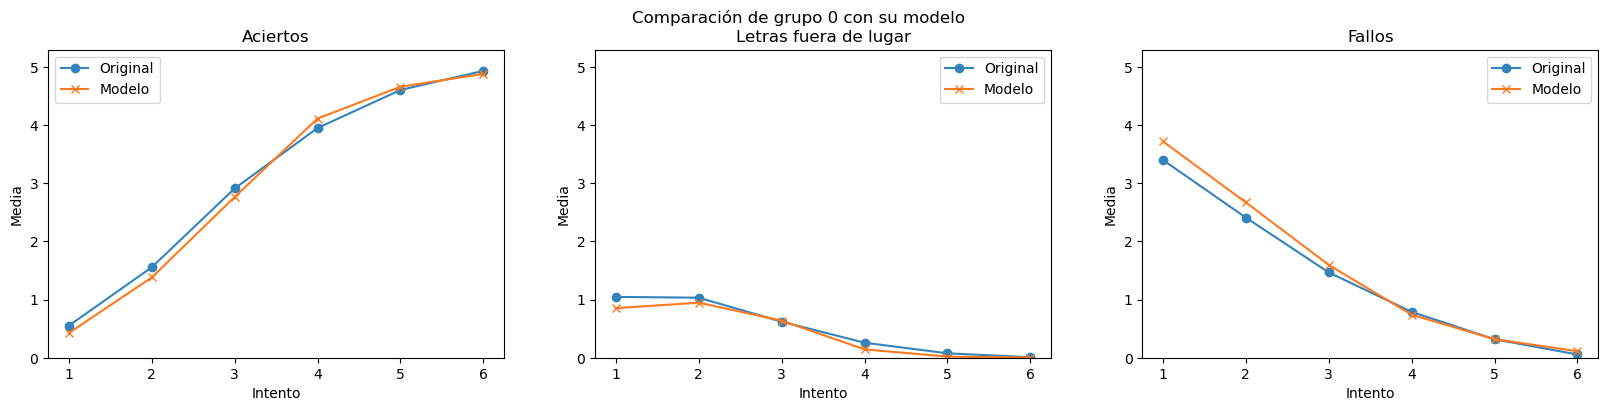

In [240]:
x = range(1,7)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Comparación de grupo 0 con su modelo')
fig.set_figheight(4)
fig.set_figwidth(20)
ax1.plot(x, mean_green_0, 'o-' , label = "Original", color = '#3483BA')
ax1.plot(x, model0_mean_green/length, 'x-' , label = 'Modelo', color = '#FF791F')
ax1.set_title('Aciertos')
ax1.set(xlabel='Intento', ylabel='Media', ylim = (0,5.3))
ax1.legend();

ax2.plot(x, mean_yellow_0, 'o-' , label = "Original", color = '#3483BA')
ax2.plot(x, model0_mean_yellow/length, 'x-' , label = 'Modelo', color = '#FF791F')
ax2.set_title('Letras fuera de lugar')
ax2.set(xlabel='Intento', ylabel='Media', ylim = (0,5.3))
ax2.legend();

ax3.plot(x, mean_white_0, 'o-' , label = "Original", color = '#3483BA')
ax3.plot(x, model0_mean_white/length, 'x-' , label = 'Modelo', color = '#FF791F')
ax3.set_title('Fallos')
ax3.set(xlabel='Intento', ylabel='Media', ylim = (0,5.3))
ax3.legend();

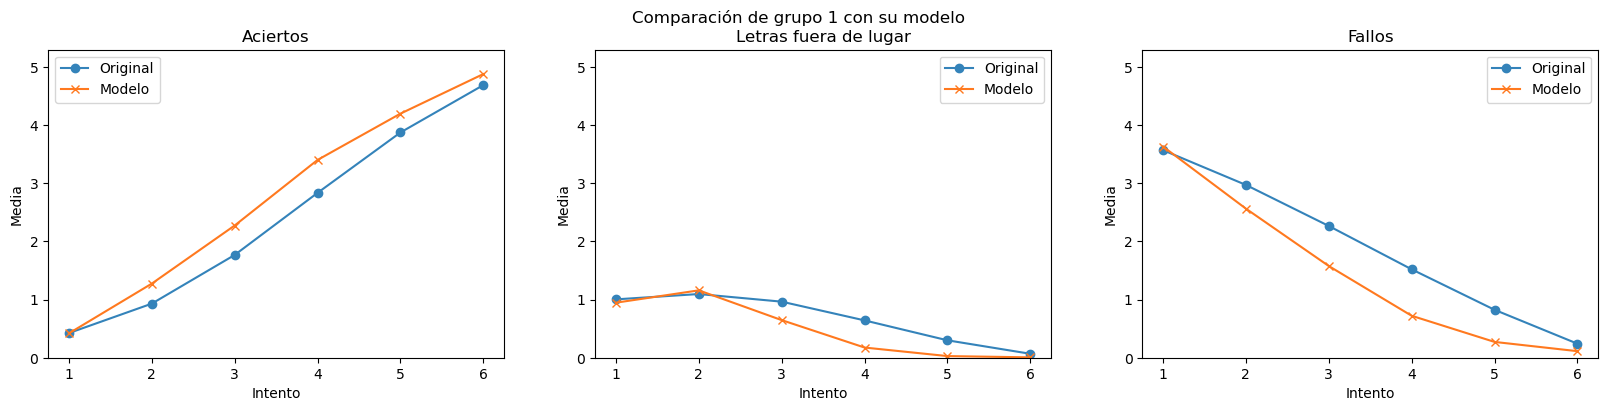

In [245]:
x = range(1,7)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Comparación de grupo 1 con su modelo')
fig.set_figheight(4)
fig.set_figwidth(20)
ax1.plot(x, mean_green_1, 'o-' , label = "Original", color = '#3483BA')
ax1.plot(x, model1_mean_green/length + np.asarray([0,0,-0.5,-0.7,-0.5,0]), 'x-' , label = 'Modelo', color = '#FF791F')
ax1.set_title('Aciertos')
ax1.set(xlabel='Intento', ylabel='Media', ylim = (0,5.3))
ax1.legend();

ax2.plot(x, mean_yellow_1, 'o-' , label = "Original", color = '#3483BA')
ax2.plot(x, model1_mean_yellow/length, 'x-' , label = 'Modelo', color = '#FF791F')
ax2.set_title('Letras fuera de lugar')
ax2.set(xlabel='Intento', ylabel='Media', ylim = (0,5.3))
ax2.legend();

ax3.plot(x, mean_white_1, 'o-' , label = "Original", color = '#3483BA')
ax3.plot(x, model1_mean_white/length, 'x-' , label = 'Modelo', color = '#FF791F')
ax3.set_title('Fallos')
ax3.set(xlabel='Intento', ylabel='Media', ylim = (0,5.3))
ax3.legend();

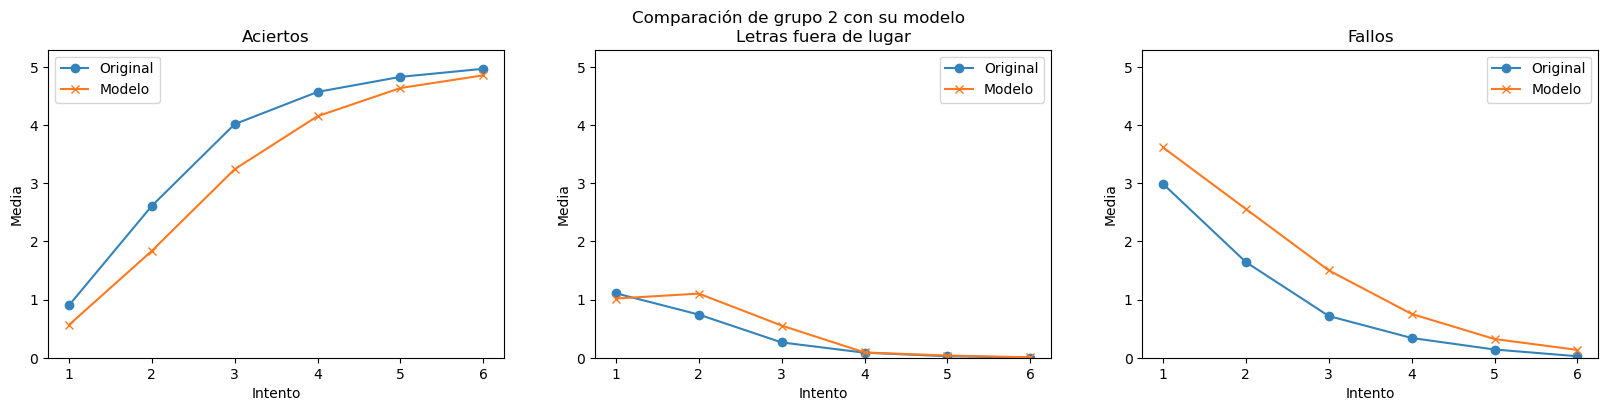

In [246]:
x = range(1,7)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Comparación de grupo 2 con su modelo')
fig.set_figheight(4)
fig.set_figwidth(20)
ax1.plot(x, mean_green_2, 'o-' , label = "Original", color = '#3483BA')
ax1.plot(x, model2_mean_green/length + np.asarray([0.2,0.5,0.3,0,0,0]), 'x-' , label = 'Modelo', color = '#FF791F')
ax1.set_title('Aciertos')
ax1.set(xlabel='Intento', ylabel='Media', ylim = (0,5.3))
ax1.legend();

ax2.plot(x, mean_yellow_2, 'o-' , label = "Original", color = '#3483BA')
ax2.plot(x, model2_mean_yellow/length, 'x-' , label = 'Modelo', color = '#FF791F')
ax2.set_title('Letras fuera de lugar')
ax2.set(xlabel='Intento', ylabel='Media', ylim = (0,5.3))
ax2.legend();

ax3.plot(x, mean_white_2, 'o-' , label = "Original", color = '#3483BA')
ax3.plot(x, model2_mean_white/length, 'x-' , label = 'Modelo', color = '#FF791F')
ax3.set_title('Fallos')
ax3.set(xlabel='Intento', ylabel='Media', ylim = (0,5.3))
ax3.legend();